In [113]:
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
#from scipy.interpolate import interp1d

def larmor_radius(KE, B, charge_mass_ratio = 9.58e7, charge_in_e = 1):
    c = 3e8
    q = (1.6e-19)*charge_in_e
    m = q/charge_mass_ratio
    E = KE+m*9e16
    p = (1/c)*np.sqrt((E**2)-((m**2)*(c**4)))
    R = p/(q*B)
    return R

def track_particle_2D(
        #input everything in SI units, except for E being in eV
        #B is in the Z direction for the 2D tracker
        Energy_eV,
        B_data = np.array([1]),
        B_axes = np.array([0]),
        theta_0 = 0,
        theta_z = 0,
        d_tcc = 0.5,
        delta_d = 0.0005,
        nonuniform_B = True,
        uniform_B = 1,
        charge_mass_ratio = 9.58e7,
        charge_in_e = 1,
        plate = 'curved',
        IP_radius = 0.20,
        IP_center = np.array([0.10,-0.10]),
        x_max = 1,
        y_max = 1,
        dynamic_step = 1,
        fine_adjustment = 16):
    #initializing variables
    E = (Energy_eV * 1.6e-19)
    x_array = []
    y_array = []
    z_array = []
    x = 0
    y = d_tcc*math.sin(theta_0)*math.cos(theta_z)
    z = d_tcc*math.sin(theta_0)
    theta = theta_0
    x_array.append(x)
    y_array.append(y)
    z_array.append(z)

    if dynamic_step < 1:
        grad_B_data = np.gradient(B_data,B_axes)
        grad_B_max = np.max(grad_B_data)
        delta_D = delta_d

#code block for curved plate
    if plate == 'curved':
        while (((x-IP_center[0])**2)+((y-IP_center[1])**2) < (IP_radius-2*delta_d)**2):
            #find the B field at the particle position
            if nonuniform_B == True:
                #adjust B field given a straight trajectory, take the B field nearer the midpoint of travel
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    #grad_B_adj has a minimum value of 1
                    #grad_B_adj increases to a maximum value of dynamic_step
                    #grad_B_adj determines h0w many times the step is reduced by
                    #dynamic_step determines the maximum value of grad_B_adj
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D/grad_B_adj
            elif nonuniform_B == False:
                B = uniform_B
            
            #find the larmor radius of the particle. If the particle has some z-momentum, the energy has a smaller 'effective energy' in the perpendicular direction
            R = larmor_radius(E*math.cos(theta_z), B, charge_mass_ratio, charge_in_e)
            
            #the distance traveled in the perp direction
            delta_theta_adjusted = delta_d*math.cos(theta_z)/R
            delta_xv = R*math.sin(delta_theta_adjusted)
            delta_yv = R*(1-math.cos(delta_theta_adjusted))
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            x = x+delta_x
            y = y+delta_y
            #the distance traveled in the par direction
            z = z+delta_d*math.sin(theta_z)
            theta = theta+delta_theta_adjusted
            x_array.append(x)
            y_array.append(y)
            z_array.append(z)

        while (((x-IP_center[0])**2)+((y-IP_center[1])**2) < IP_radius**2):
            if nonuniform_B == True:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D/grad_B_adj
            elif nonuniform_B == False:
                B = uniform_B

            R = larmor_radius(E*math.cos(theta_z), B, charge_mass_ratio, charge_in_e)

            delta_theta_adjusted = delta_d*math.cos(theta_z)/(R*fine_adjustment)
            delta_xv = R*math.sin(delta_theta_adjusted)
            delta_yv = R*(1-math.cos(delta_theta_adjusted))
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            x = x+delta_x
            y = y+delta_y
            z = z+delta_d*math.sin(theta_z)
            theta = theta+delta_theta_adjusted
            x_array.append(x)
            y_array.append(y)
            z_array.append(z)
            
# code block for flat plate
    if plate == 'flat':
        while 0 < x < x_max-delta_d and y < y_max-delta_d:
            if nonuniform_B == True:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D/grad_B_adj
            elif nonuniform_B == False:
                B = uniform_B
            
            R = larmor_radius(E*math.cos(theta_z), B, charge_mass_ratio, charge_in_e)
            
            delta_theta_adjusted = delta_d*math.cos(theta_z)/R
            delta_xv = R*math.sin(delta_theta_adjusted)
            delta_yv = R*(1-math.cos(delta_theta_adjusted))
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            x = x+delta_x
            y = y+delta_y
            z = z+delta_d*math.sin(theta_z)
            theta = theta+delta_theta_adjusted
            x_array.append(x)
            y_array.append(y)
            z_array.append(z)

        while 0 < x < x_max and y < y_max:
            if nonuniform_B == True:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D/grad_B_adj
            elif nonuniform_B == False:
                B = uniform_B

            R = larmor_radius(E*math.cos(theta_z), B, charge_mass_ratio, charge_in_e)

            delta_theta_adjusted = delta_d*math.cos(theta_z)/(R*fine_adjustment)
            delta_xv = R*math.sin(delta_theta_adjusted)
            delta_yv = R*(1-math.cos(delta_theta_adjusted))
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            x = x+delta_x
            y = y+delta_y
            z = z+delta_d*math.sin(theta_z)
            theta = theta+delta_theta_adjusted
            x_array.append(x)
            y_array.append(y)
            z_array.append(z)
            
    return np.array(x_array), np.array(y_array)




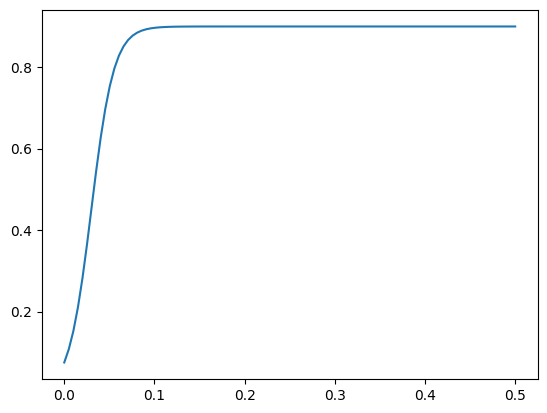

In [143]:
Baxes = np.linspace(0,0.5,100)
#Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.05)))
Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.030)))

IPradius = 0.14
IPcenter = np.array([0.06,-0.12])

E = 500

solidangle = 0.002
N_particles = 51
thetarange = math.pi*np.linspace(-solidangle,solidangle,N_particles)

plt.plot(Baxes,Bdata)

-0.6409829640286238


(-0.03, 0.03)

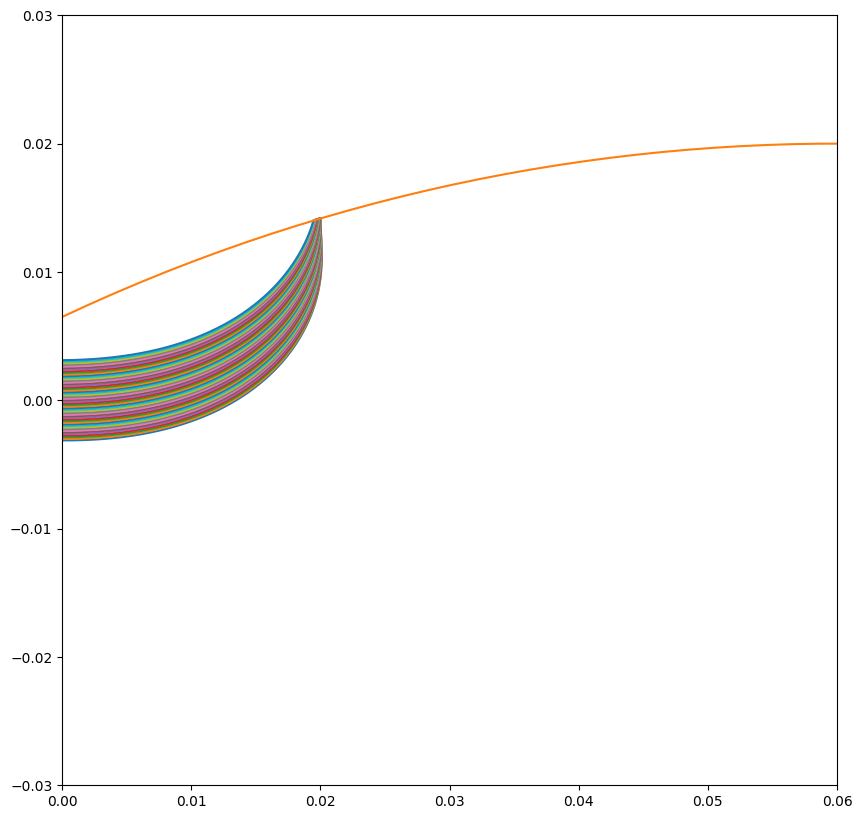

In [144]:
plt.figure(figsize = (10,10))

X_data = []
Y_data = []

for theta in thetarange:
    X, Y = track_particle_2D(
        E,
        B_data = Bdata,
        B_axes = Baxes,
        theta_0 = theta,
        theta_z = (1/32)*math.pi,
        d_tcc = 0.5,
        delta_d = 0.000025,
        nonuniform_B = True,
        uniform_B = 1,
        charge_mass_ratio = 9.58e7,
        charge_in_e = 1,
        plate = 'curved',
        IP_radius = IPradius,
        IP_center = IPcenter,
        )

    plt.plot(X,Y)
    X_data.append(X[-1])
    Y_data.append(Y[-1])

XIP_data = np.array(X_data-IPcenter[0])
YIP_data = np.array(Y_data-IPcenter[1])

#rotate axes to calculate angle from start of IP
theta_0_IP = -math.pi + math.atan(np.sqrt(IPradius**2-(IPcenter[0])**2)/IPcenter[0])
print(theta_0_IP/math.pi)
Xprime = math.cos(theta_0_IP)*XIP_data-math.sin(theta_0_IP)*YIP_data
Yprime = math.sin(theta_0_IP)*XIP_data+math.cos(theta_0_IP)*YIP_data

#using atan to find angle from start of IP
theta_IP_prime = np.zeros(len(Yprime)) 
for i in range(len(Yprime)):
    theta_IP_prime[i] = -math.atan(Yprime[i]/Xprime[i])

#now we can find the distance along the IP
IP_dist_val = theta_IP_prime*IPradius
#print(IP_dist_val)
#IP_reading_val = np.array(sorted(IP_dist_val))
#print(IP_reading_val)

#now we find the average distance between particles on the IP
interpart_dist = np.zeros(len(IP_dist_val))
interpart_dist[0] = 2*(np.abs(IP_dist_val[1]-IP_dist_val[0]))
interpart_dist[-1] = 2*(np.abs(IP_dist_val[-1]-IP_dist_val[-2]))
for i in range(len(IP_dist_val)-2):
    interpart_dist[i+1] = np.abs(IP_dist_val[i+2]-IP_dist_val[i+1])+np.abs(IP_dist_val[i+1]-IP_dist_val[i+0])


#the particle density is just the inverse of the interparticle spacing
particle_dens = 1/interpart_dist

IP_x = np.linspace(0,0.20,100)
IP_y = IPcenter[1]+np.sqrt(IPradius**2-(IP_x-IPcenter[0])**2)
plt.plot(IP_x,IP_y)

plt.xlim(0,0.06)
plt.ylim(-0.03,0.03)

#plt.xlim(0.02-0.005,0.02+0.005)
#plt.ylim(0.013-0.005,0.013+0.005)

24
50
Normal incidence IP position: 0.021459137200008523


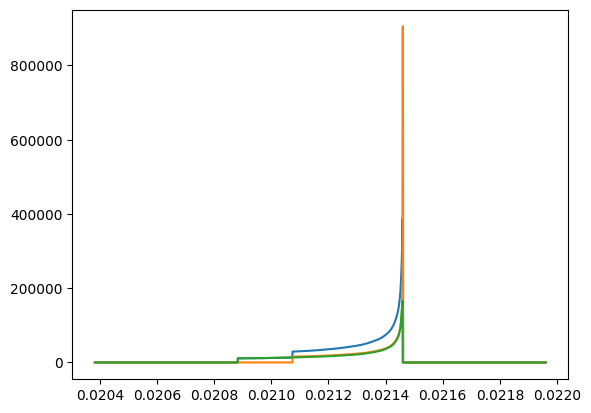

In [147]:
max = np.max(IP_dist_val)
for i in range(len(IP_dist_val)):
    if IP_dist_val[i] == max:
        max_index = i
print(max_index)
print(len(IP_dist_val)-1)
print('Normal incidence IP position:',IP_dist_val[int(0.5*len(IP_dist_val))])

if max_index == 0:
    interpart_dist_a = np.zeros(len(IP_dist_val))
    interpart_dist_a[0] = 2*(np.abs(IP_dist_val[1]-IP_dist_val[0]))
    interpart_dist_a[-1] = 2*(np.abs(IP_dist_val[-1]-IP_dist_val[-2]))
    
    for i in range(len(IP_dist_val)-2):
        interpart_dist_a[i+1] = np.abs(IP_dist_val[i+2]-IP_dist_val[i+1])+np.abs(IP_dist_val[i+1]-IP_dist_val[i+0])
    
    IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
    interp_interpart_a = np.interp(IP_linspace, np.flip(IP_dist_val), np.flip(interpart_dist_a), left=1e7, right=1e7)

    Particle_Density_a = 1/interp_interpart_a
    Particle_Density_b = 0*IP_linspace
    Particle_Density = 1/interp_interpart_a
elif 2 < max_index < ((len(IP_dist_val))-3):

    IP_dist_a = IP_dist_val[:max_index+1]
    IP_dist_b = IP_dist_val[max_index+1:]

    interpart_dist_a = np.zeros(len(IP_dist_a))
    interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
    interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
    for i in range(len(IP_dist_a)-2):
        interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

    interpart_dist_b = np.zeros(len(IP_dist_b))
    interpart_dist_b[0] = 2*(np.abs(IP_dist_b[1]-IP_dist_b[0]))
    interpart_dist_b[-1] = 2*(np.abs(IP_dist_b[-1]-IP_dist_b[-2]))
    for i in range(len(IP_dist_b)-2):
        interpart_dist_b[i+1] = np.abs(IP_dist_b[i+2]-IP_dist_b[i+1])+np.abs(IP_dist_b[i+1]-IP_dist_b[i+0])

    IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
    interp_interpart_a = np.interp(IP_linspace, IP_dist_a, interpart_dist_a, left=1e7, right=1e7)
    interp_interpart_b = np.interp(IP_linspace, np.flip(IP_dist_b), np.flip(interpart_dist_b), left=1e7, right=1e7)

    Particle_Density_a = 1/interp_interpart_a
    Particle_Density_b = 1/interp_interpart_b
    Particle_Density = 1/interp_interpart_a + 1/interp_interpart_b
elif max_index < 3:
    IP_dist_a = IP_dist_val[max_index:]
    
    interpart_dist_a = np.zeros(len(IP_dist_a))
    interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
    interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
    for i in range(len(IP_dist_a)-2):
        interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

    IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
    interp_interpart_a = np.interp(IP_linspace, np.flip(IP_dist_a), np.flip(interpart_dist_a), left=1e7, right=1e7)
    
    Particle_Density_a = 1/interp_interpart_a
    Particle_Density_b = 0*IP_linspace
    Particle_Density = 1/interp_interpart_a
else:
    IP_dist_a = IP_dist_val[:max_index+1]
    
    interpart_dist_a = np.zeros(len(IP_dist_a))
    interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
    interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
    for i in range(len(IP_dist_a)-2):
        interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

    IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
    interp_interpart_a = np.interp(IP_linspace, IP_dist_a, interpart_dist_a, left=1e7, right=1e7)
    
    Particle_Density_a = 1/interp_interpart_a
    Particle_Density_b = 0*IP_linspace
    Particle_Density = 1/interp_interpart_a

plt.plot(IP_linspace, Particle_Density)
plt.plot(IP_linspace, Particle_Density_a)
plt.plot(IP_linspace, Particle_Density_b)

#plt.xlim(np.min(IP_dist_b)-0.0001,np.max(IP_dist_b)+0.0001)

47
0.021494903622150327
-0.00031733259127169657


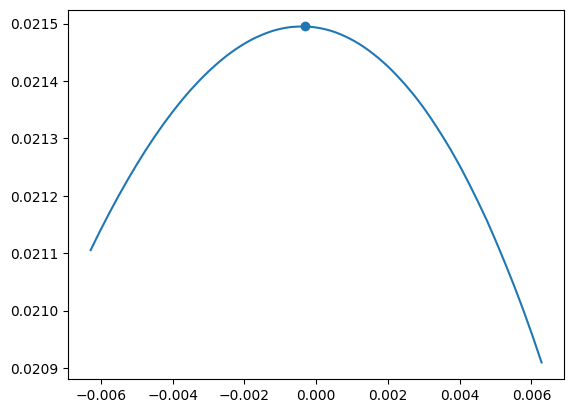

In [51]:
theta_fine = np.linspace(thetarange[0],thetarange[-1],100)
fine_dist_val = np.interp(theta_fine, thetarange, IP_dist_val)
plt.plot(theta_fine,fine_dist_val)
max = np.max(fine_dist_val)
for i in range(len(fine_dist_val)):
    if fine_dist_val[i] == max:
        max_index = i
print(max_index)
print(max)
print(theta_fine[max_index])
plt.scatter(theta_fine[max_index],max)



1625


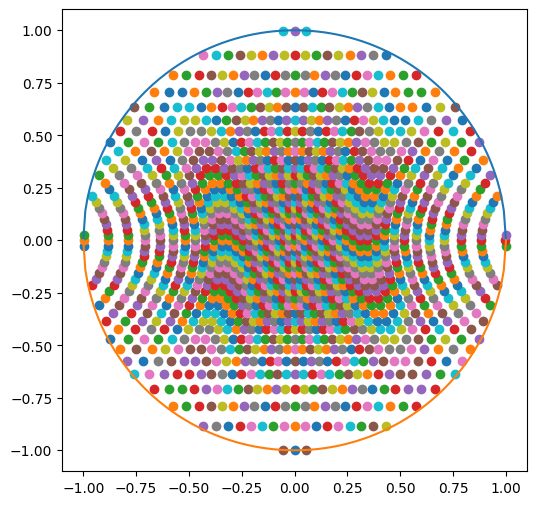

In [148]:
plt.figure(figsize = (6,6))

#print(math.tan(math.atan(1)))

import math
import numpy as np
import matplotlib.pyplot as plt
def init_circ_slit(dtcc, r, deltatheta):
    m_max = math.floor((1/deltatheta)*math.atan(r/dtcc))
    m_min = -m_max
    #print(m_max)
    mspace = np.linspace(m_min,m_max,m_max-m_min+1)
    narray = []
    marray = []
    for m in mspace:
        z_m = dtcc*math.tan(m*deltatheta)
        if abs(z_m) > r:
            z_m = (z_m/abs(z_m))*(abs(z_m)-(1e-15))
        #print(z_m)
        #print(f"{m}", end='\r')
        y_max = np.sqrt((r**2)-(z_m**2))
        n_max = math.floor((1/deltatheta)*math.atan(y_max/dtcc))
        y_max_corr = 2*r
        z_m_corr = 2*r
        while (y_max_corr**2)+(z_m_corr**2) > r**2:
            z_m_corr = z_m/math.cos((n_max*deltatheta))
            y_max_corr = dtcc*math.tan(n_max*deltatheta)
            if (y_max_corr**2)+(z_m_corr**2) > r**2:
                n_max = n_max-1
        n_min = -n_max
        nspace = np.linspace(n_min,n_max,n_max-n_min+1)
        narray.append(nspace)
        #marray.append(m*np.ones(n_max-n_min+1))
        #for n in nspace:
            #plt.scatter(dtcc*math.tan(n*deltatheta),dtcc*math.tan(m*deltatheta))
    return narray, m_min, m_max #, marray

def init_circ_boundary(dtcc, r, deltatheta):
    theta_axis = math.atan(r/dtcc)
    thetarange = np.linspace(0,2*math.pi,int(2*math.pi/deltatheta)+1)
    i = 0
    vy = np.zeros(len(thetarange))
    vz = np.zeros(len(thetarange))
    while i < len(thetarange):
        vy[i] = math.sin(theta_axis)*math.cos(thetarange[i])
        vz[i] = math.sin(theta_axis)*math.sin(thetarange[i])
        i = i+1
    vx = math.cos(theta_axis)
    return vx, vy, vz
    

dtcc = 0.5
r = 1
deltatheta = 4*0.0040
N, m_min, m_max= init_circ_slit(dtcc,r,deltatheta*math.pi)
len_array = np.zeros(m_max-m_min+1)
for i in range(m_max-m_min+1):
    len_array[i] = len(N[i])
target_array = np.zeros((m_max-m_min+1),(np.max(len_array)-np.min(len_array)+1))


vx,vy,vz = init_circ_boundary(dtcc, r, 10*deltatheta*math.pi)


#loop for going through each particle
i = 0
n_part = 0
while i < (m_max-m_min+1):
    for j in N[i]:
        n = j
        m = i+m_min
        plt.scatter(dtcc*math.tan(m*deltatheta*math.pi)*(1/math.cos(n*deltatheta*math.pi)),dtcc*math.tan(n*deltatheta*math.pi))
        #plt.scatter(dtcc*math.tan(m*deltatheta*math.pi),dtcc*math.tan(n*deltatheta*math.pi))
        n_part = n_part+1
        #print(f"Processing item at index: {n_part}", end='\r')
    i = i+1

#loop for finding the area occupied by each particle



print(n_part)

x = np.linspace(-1,1,201)
plt.plot(x,np.sqrt((1**2)-(x**2)))
plt.plot(x,-np.sqrt((1**2)-(x**2)))

scale = np.sqrt((dtcc**2)+(r**2))/r
#plt.scatter(scale*vz,scale*vy)
#print(vy)
#print(vz)

#plt.xlim(-0.5,-0.25)
#plt.ylim(-1,-0.75)

#plt.ylim(-0.75,-0.5)
#plt.xlim(0.75,1)
